## 回归预测x和y的关系--优化器

> 在前面的文档中，我们体验了手动计算/`PyTorch`自动求导，得到w和b的偏导数(得到梯度)。然后指定一个学习率，来修改`params`。    
> 我们使用的是批量梯度下降进行的优化，这里我们只`w`和`b`2个参数，如果模型很大，参数很多很复杂时，我们的这个方式就不适合了。


`torch`模块中的`optim`子模块实现了不同的优化算法的类。我们可以使用它们。

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123456)

print("")

### 1. 查看实现的优化器

In [2]:
import torch.optim as optim

In [3]:
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

> 每个优化器构造函数都需要接受一个参数列表(`PyTorch`张量，通常设置`requires_grad`为`True`)作为第一个输入。

每个优化器公开2个方法：
- `zero_grad()`： 传递给优化器构造函数中的所有参数的`grad`属性归零。
- `step()`：根据特定优化器实现的优化策略更新这些参数的值。

### 2. 使用梯度下降优化器

#### 2.1 准备x、y和model以及损失函数

In [4]:
# x and y
x = [-6.0, -4.0, -1.2, -1.6, 1.0, 1.5, 2.3, 1.9, 3.3, 4.2, 5.0, 7.7, 8.2]
x = torch.tensor(x)

y = torch.tensor([
    -36.8778, -26.4276, -19.5442, -20.2848, -10.5902, -13.0207, -10.1414, -9.3716,
    -4.7571,  -1.8561, 1.2260,  12.6646,  12.8662
])

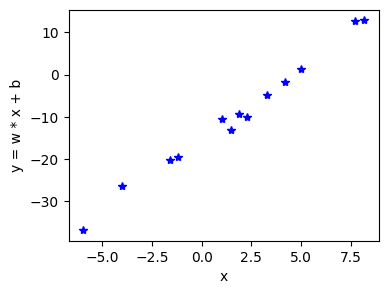

In [5]:
# 显示x、y的点
fig = plt.figure(figsize=(4,3), dpi=100)
plt.xlabel("x")
plt.ylabel("y = w * x + b")
plt.plot(x.numpy(), y.numpy(), '*', color="blue")
plt.show()

In [6]:
# model and loss function
# 模型
def model(source, w, b):
    return w * source + b

# 损失函数
def loss_function(predict, real_value):
    squared_diffs = (predict - real_value)**2
    return squared_diffs.mean()

#### 2.2 实例化梯度下降优化器

In [7]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-4
optimizer = optim.SGD([params], lr=learning_rate)

In [8]:
type(optimizer)

torch.optim.sgd.SGD

In [9]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

#### 2.3 调用优化器

In [10]:
params

tensor([1., 0.], requires_grad=True)

In [11]:
predict = model(x, *params)
loss = loss_function(predict, y)

# 反向传播
loss.backward()

# 执行优化器的step()
optimizer.step()

# 查看新的params
print(params)

tensor([ 1.0038, -0.0023], requires_grad=True)


`params`的值在调用`optimizer.step()`时更新，不需要我们自己去操作修改`params`。   
> 优化器会查看`params.grad`并更新`params`，从中减去学习率(learning_rate）乘以梯度(params.grad)，和我们以前手动编写的一样。

In [12]:
params.grad

tensor([-38.3199,  22.8330])

In [13]:
# 给梯度归零
optimizer.zero_grad()

In [14]:
params

tensor([ 1.0038, -0.0023], requires_grad=True)

> **发现，我们现在的params,其实也是：`params -  learning_rate * params.grad`后的值**

In [15]:
# 调用了zero_grad()之后，`params`的`grad`属性就归零了
params.grad is None

True

#### 2.4 训练循环

In [16]:
def training_loop(epochs, optimizer, params, source, real_value, print_step):
    for epoch in range(epochs):
        # 先对参数的梯段置零
        optimizer.zero_grad()

        # 正向传播：计算预测值
        predict = model(source, *params)
        # 计算损失
        loss = loss_function(predict, real_value)
        # print(epoch, "loss is", loss)
        # 反向传播: 更新params的梯度
        loss.backward()
        # 不需要手动去修改params了，直接调用优化器的step()
        optimizer.step()
            
        # 输出日志信息
        if  epoch == 0 or (epoch + 1) % print_step == 0:
            print("第{}次训练, Loss is {:.2f}, params: {}".format(epoch + 1, float(loss), params))
    # 返回参数
    return params

In [17]:
# 准备训练循环所需的参数
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
# SGD：随机梯度下降
optimizer = optim.SGD([params], lr=learning_rate)

# 调用训练循环
training_loop(
    epochs=1500,
    optimizer=optimizer,
    params=params,
    source=x,
    real_value=y,
    print_step=100
)

第1次训练, Loss is 225.49, params: tensor([ 1.3832, -0.2283], requires_grad=True)
第100次训练, Loss is 9.45, params: tensor([  3.1286, -12.6548], requires_grad=True)
第200次训练, Loss is 2.45, params: tensor([  3.3491, -15.0017], requires_grad=True)
第300次训练, Loss is 2.22, params: tensor([  3.3897, -15.4340], requires_grad=True)
第400次训练, Loss is 2.21, params: tensor([  3.3972, -15.5136], requires_grad=True)
第500次训练, Loss is 2.21, params: tensor([  3.3986, -15.5283], requires_grad=True)
第600次训练, Loss is 2.21, params: tensor([  3.3989, -15.5310], requires_grad=True)
第700次训练, Loss is 2.21, params: tensor([  3.3989, -15.5315], requires_grad=True)
第800次训练, Loss is 2.21, params: tensor([  3.3989, -15.5315], requires_grad=True)
第900次训练, Loss is 2.21, params: tensor([  3.3989, -15.5315], requires_grad=True)
第1000次训练, Loss is 2.21, params: tensor([  3.3989, -15.5315], requires_grad=True)
第1100次训练, Loss is 2.21, params: tensor([  3.3989, -15.5315], requires_grad=True)
第1200次训练, Loss is 2.21, params: tensor([

tensor([  3.3989, -15.5315], requires_grad=True)

#### 2.5 图形展示

In [18]:
# x中的点
x_line = np.linspace(-10,10,500)
# 计算y的点
y_line = params[0].item() * x_line + params[1].item()

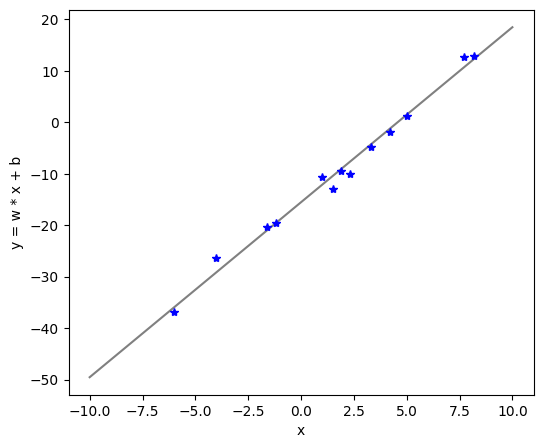

In [19]:
# 画图
fig = plt.figure(figsize=(6,5), dpi=100)
plt.xlabel("x")
plt.ylabel("y = w * x + b")
plt.plot(x_line, y_line, label="y = w*x + b", color="gray")
plt.plot(x.numpy(), y.numpy(), '*', color="blue")
plt.show()

**注意：** 我们使用优化器计算出的`w`和`b`和自动求导，手动求导，计算出的值是一致的。   
在后续的模型训练中，我们就可以使用一些模块中的优化器了。根据自己项目的需求，选择合适的优化器。